In [1]:
!pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-cp36-none-any.whl size=7100 sha256=6417dc57e095bfb2cb62d936c61cf80fde9f24b5ab2a6fa8d5dbf44004544acd
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjustText


In [0]:
import os
import json
from functools import *
import requests
import numpy as np
import pandas as pd
from google.colab import drive
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
import plotnine as p9
from adjustText import adjust_text
import plotnine as p9

In [4]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def download_relevant_data(gdrive_folder='/content/drive/My Drive/tnp_pagerank/'):
  '''
  Downloads relevant tnp data from City of Chicago data portal and
  saves into specificed Google drive folder

  Inputs:
    gdrive_folder(str): folder in which csvs should be saved

  Outputs: None (saved csvs)
  '''
  os = 0
  params = {'$limit': 1000, '$offset': os}
  response = requests.get('https://data.cityofchicago.org/resource/' + \
                          'm6dm-c72p.json?$where=trip_start_timestamp%20' + \
                          'between%20%272019-05-01T00:00:00%27%20and'+ \
                          '%20%272019-06-01T00:00:00%27', params).json()
  total_response = response
  os = 1000
  i = 1
  while len(response) >= 1000:
      if os % 500000 == 0:
        df = pd.DataFrame.from_dict(total_response)
        df.to_csv(gdrive_folder + f'tnp_may2019_{i}.csv')
        i += 1
        total_response = []
      params = {'$limit': 1000, '$offset': os}
      response = requests.get('https://data.cityofchicago.org/resource/' + \
                              'm6dm-c72p.json?$where=trip_start_timestamp' + \
                              '%20between%20%272019-05-01T00:00:00%27%20' + \
                              'and%20%272019-06-01T00:00:00%27', params).json()
      os += 1000
      total_response += response

In [0]:
def create_counts_df(folder="/content/drive/My Drive/Math ML project" + \
                     "/tnp_pagerank/train_data"):
  '''
  Reads in the csvs from specified folder and creates a dataframe with each row 
  as a pickup dropoff community area combination and each column as the count
  between the two for each csv

  Inputs:
    folder(str): folder in which csvs are stored

  Outputs:
    total_count_df: a pandas dataframe
  '''
  count_df_lst = []
  for csv in os.listdir(folder):
    one_csv_df = pd.read_csv(f"{folder}/{csv}", index_col=0)
    community_area_cols = ['pickup_community_area', 'dropoff_community_area']
    one_csv_df.dropna(subset=community_area_cols, inplace=True)
    for col in community_area_cols:
      one_csv_df[col] = one_csv_df[col].astype(int)
      one_csv_df[col] = one_csv_df[col].astype(str)
    one_csv_df['pickup_dropoff'] = one_csv_df['pickup_community_area'] + '_' + \
                                   one_csv_df['dropoff_community_area']
    count_df = pd.DataFrame({'count': one_csv_df.groupby('pickup_dropoff'). \
                                                 size()}).reset_index()
    count_df_lst.append(count_df)
  total_count_df = reduce(lambda x, y: pd.merge(x, y, on=['pickup_dropoff'],
                                                how='outer'), count_df_lst)
  return total_count_df

In [7]:
total_count_df = create_counts_df()
total_count_df.head()

,pickup_dropoff,count_x,count_y,count_x,count_y,count_x,count_y,count_x,count_y,count_x,count_y,count_x,count_y,count_x,count_y,count_x,count_y,count_x,count_y,count_x,count_y
0,10_1,3.0,8.0,12.0,14.0,15.0,15.0,11.0,11.0,11.0,6.0,9.0,10.0,13.0,9.0,6.0,13.0,11.0,10.0,NaN,13.0
1,10_10,202.0,180.0,155.0,172.0,181.0,180.0,174.0,170.0,189.0,183.0,199.0,187.0,194.0,193.0,186.0,203.0,162.0,186.0,22.0,226.0
2,10_11,84.0,58.0,78.0,76.0,65.0,76.0,55.0,75.0,66.0,55.0,67.0,84.0,95.0,72.0,69.0,79.0,79.0,84.0,14.0,93.0
3,10_12,23.0,16.0,23.0,25.0,17.0,18.0,15.0,22.0,25.0,23.0,18.0,16.0,27.0,24.0,25.0,36.0,33.0,32.0,6.0,19.0
4,10_13,13.0,8.0,13.0,8.0,10.0,12.0,4.0,10.0,14.0,15.0,8.0,6.0,9.0,10.0,7.0,8.0,14.0,8.0,1.0,14.0


In [0]:
def read_and_clean(folder="/content/drive/My Drive/Math ML " + \
                   "project/tnp_pagerank/train_data"):
  '''
  Reads in csvs to pandas dataframes;
  Lightly cleans concatenates dataframes

  Inputs:
    folder(str): folder in which csvs are located
  
  Outputs:
    big_df: a pandas dataframe with all the data
  '''
  big_df_lst = []
  for csv in os.listdir(folder):
    one_csv_df = pd.read_csv(f"{folder}/{csv}", index_col=0)
    community_area_cols = ['pickup_community_area', 'dropoff_community_area']
    one_csv_df.dropna(subset=community_area_cols, inplace=True)
    big_df_lst.append(one_csv_df)
  big_df = pd.concat(big_df_lst, sort=True)
  return big_df

In [10]:
big_df = read_and_clean()
big_df.head()

,additional_charges,dropoff_census_tract,dropoff_centroid_latitude,dropoff_centroid_location,dropoff_centroid_longitude,dropoff_community_area,fare,pickup_census_tract,pickup_centroid_latitude,pickup_centroid_location,pickup_centroid_longitude,pickup_community_area,shared_trip_authorized,tip,trip_end_timestamp,trip_id,trip_miles,trip_seconds,trip_start_timestamp,trip_total,trips_pooled
3,2.55,1.703106e+10,41.957904,"{'type': 'Point', 'coordinates': [-87.67151801...",-87.671518,6.0,2.5,1.703183e+10,41.946295,"{'type': 'Point', 'coordinates': [-87.65429808...",-87.654298,6.0,False,0,2019-05-01T00:00:00.000,001ab3a53a4f74430d2a9aae216fed703244cfc9,1.455387,300.0,2019-05-01T00:00:00.000,5.05,1
4,0.00,NaN,41.938666,"{'type': 'Point', 'coordinates': [-87.71121059...",-87.711211,21.0,5.0,NaN,41.953582,"{'type': 'Point', 'coordinates': [-87.72345239...",-87.723452,16.0,True,0,2019-05-01T00:00:00.000,006cb41cca5aa81d9b9676ea19b9f39cbda1b981,0.701593,209.0,2019-05-01T00:00:00.000,5.00,1
5,2.55,NaN,42.009623,"{'type': 'Point', 'coordinates': [-87.67016685...",-87.670167,1.0,10.0,NaN,41.975171,"{'type': 'Point', 'coordinates': [-87.68751551...",-87.687516,4.0,False,0,2019-05-01T00:15:00.000,0091e302ff1966153f6c984417772e1ef25bbe59,4.621039,916.0,2019-05-01T00:00:00.000,12.55,1
7,2.55,NaN,41.947792,"{'type': 'Point', 'coordinates': [-87.68383494...",-87.683835,5.0,5.0,NaN,41.944227,"{'type': 'Point', 'coordinates': [-87.65599818...",-87.655998,6.0,False,0,2019-05-01T00:15:00.000,00e561761b8ca6e75ff50d5260c2bd697373eff5,2.146416,506.0,2019-05-01T00:00:00.000,7.55,1
9,0.72,1.703183e+10,41.946295,"{'type': 'Point', 'coordinates': [-87.65429808...",-87.654298,6.0,7.5,1.703108e+10,41.892073,"{'type': 'Point', 'coordinates': [-87.62887415...",-87.628874,8.0,True,0,2019-05-01T00:15:00.000,01080eb6fc1bd9ec70e3fd8a2a56345754b92332,5.680133,1020.0,2019-05-01T00:00:00.000,8.22,2


In [0]:
def make_pickup_dropoff_df(trips_df, rel_cols=['pickup_community_area',
                                               'dropoff_community_area']):
  '''
  Turns dataframe with each row as a trip into a dataframe where each row as
  a community area with the columns as the total number of pickups and dropoffs
  for each community area

  Inputs:
    trips_df: pandas df where each row is a trip
    rel_cols: list of columns, one w/ pickup area & one with dropoff area

  Outputs:
    pickup_dropoff_count_df: a pandas df wher each row is a community area
  '''
  grouped_lst = []
  for col in rel_cols:
    grouped = pd.DataFrame(trips_df.groupby(col).size()).reset_index(). \
                                  rename(columns={0: f'{col[:-15]}_count',
                                                  col: 'community_area'})
    grouped_lst.append(grouped)
  pickup_dropoff_count_df = reduce(lambda x, y: pd.merge(x, y,
                                                         on=['community_area'],
                                                         how='outer'),
                                   grouped_lst)
  return pickup_dropoff_count_df

In [12]:
pickup_dropoff_count_df = make_pickup_dropoff_df(big_df)
pickup_dropoff_count_df.head()

,community_area,pickup_count,dropoff_count
0,1.0,81375,82727
1,2.0,60922,58159
2,3.0,187048,181476
3,4.0,89481,92957
4,5.0,108976,107434


In [0]:
def apply_zone_fn(x):
  zone_dict = {'NORTH': 1, 'SOUTH': 2, 'WEST': 3, 'EAST': 4, 'CENTRAL': 5}
  zone = x['zone']
  return zone_dict[zone]

In [14]:
# below we add neighborhood side & corresponding zone int to our dataframe
#(North, South, East, West, Central)
neighborhoods_by_side = pd.read_csv('https://raw.githubusercontent.com/' + \
                                    'katykoenig/machine-learning-for-public' + \
                                    '-policy/master/hw1/community-areas.csv')
neighborhoods_by_side = neighborhoods_by_side[['zone', 'id']]
count_w_sides = pickup_dropoff_count_df.merge(neighborhoods_by_side,
                                              left_on='community_area',
                                              right_on='id')
count_w_sides['zone_int'] = count_w_sides.apply(lambda x: apply_zone_fn(x),
                                                axis=1)
count_w_sides.head()

,community_area,pickup_count,dropoff_count,zone,id,zone_int
0,1.0,81375,82727,NORTH,1,1
1,2.0,60922,58159,NORTH,2,1
2,3.0,187048,181476,NORTH,3,1
3,4.0,89481,92957,NORTH,4,1
4,5.0,108976,107434,NORTH,5,1


In [15]:
# Add community area name
comm_areas = pd.read_csv('/content/drive/My Drive/Math ML project/' + \
                         'chicago-community-areas.csv', index_col=0).T['name']
comm_names_dict = comm_areas.to_dict()
count_w_sides['community_area'] = count_w_sides['community_area'].astype(int). \
                                                                  astype(str)
count_w_comm_names = count_w_sides.set_index('community_area').T. \
                                   rename(columns=comm_areas).T.reset_index()
count_w_comm_names.head()

,community_area,pickup_count,dropoff_count,zone,id,zone_int
0,Rogers Park,81375,82727,NORTH,1,1
1,West Ridge,60922,58159,NORTH,2,1
2,Uptown,187048,181476,NORTH,3,1
3,Lincoln Square,89481,92957,NORTH,4,1
4,North Center,108976,107434,NORTH,5,1


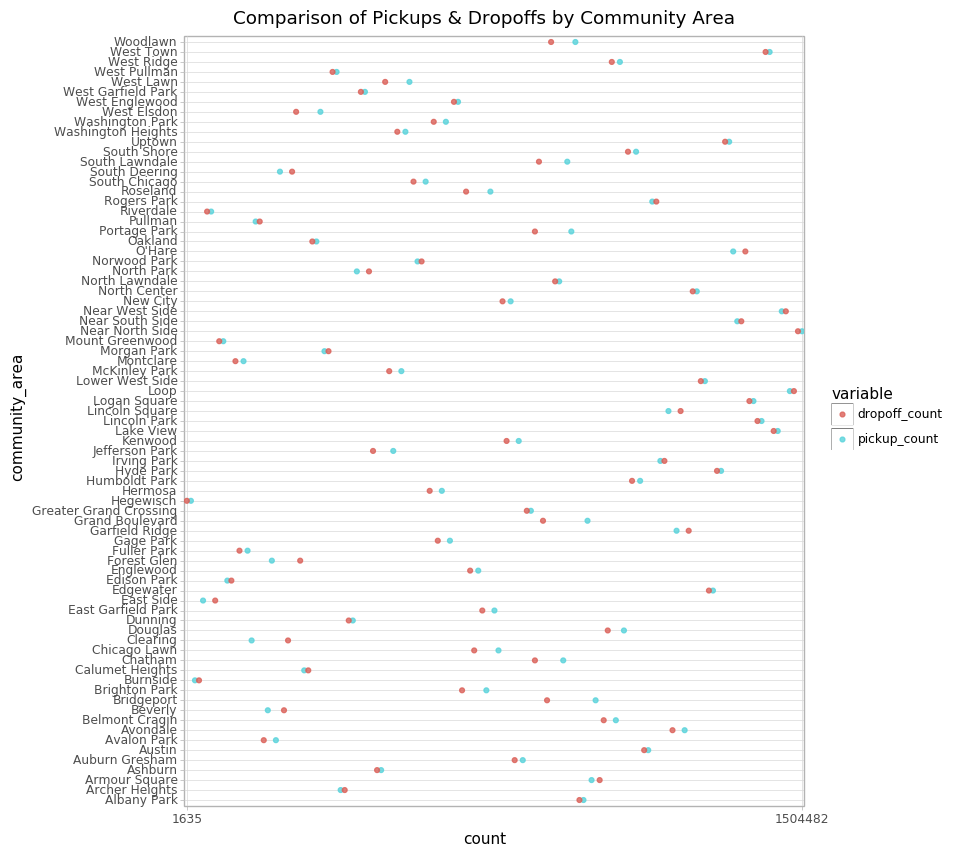

<ggplot: (8782253393910)>

In [16]:
melted_comm_names = pd.melt(count_w_comm_names, id_vars=['community_area', 'id',
                                                         'zone_int', 'zone'])
melted_comm_names.rename(columns={'value': 'count'}, inplace=True)
x_scale = np.linspace(melted_comm_names['count'].min(),
                      melted_comm_names['count'].max(), 50000)
p9.ggplot(melted_comm_names, p9.aes('count', 'community_area')) + \
  p9.geom_point(p9.aes(color='variable'), alpha=0.8) + p9.theme_light() + \
  p9.theme(figure_size=(8, 10)) + p9.scale_x_discrete(breaks=x_scale) + \
  p9.ggtitle("Comparison of Pickups & Dropoffs by Community Area")

500

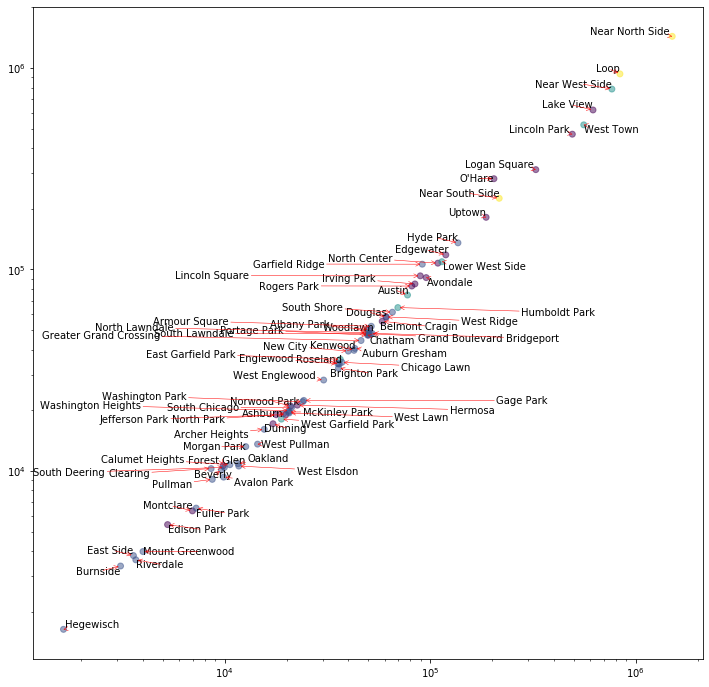

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(count_w_comm_names['pickup_count'],
            count_w_comm_names['dropoff_count'], alpha=0.5,
            c=count_w_comm_names['zone_int'])
x = np.linspace(min(count_w_comm_names['pickup_count']),
                max(count_w_comm_names['pickup_count']), 500)
y = np.linspace(min(count_w_comm_names['dropoff_count']),
                max(count_w_comm_names['dropoff_count']), 500)
texts = [plt.text(count_w_comm_names['pickup_count'][i],
                  count_w_comm_names['dropoff_count'][i],
                  count_w_comm_names['community_area'][i],
                  ha='center', va='center') for i in  \
         range(len(count_w_comm_names['pickup_count']))]
plt.yscale("log")
plt.xscale("log")
adjust_text(texts, x, y, arrowprops=dict(arrowstyle="->", color='r', lw=0.5),
            only_move={'points':'x', 'text':'x'})

In [0]:
def convert_to_adj_matrix(count_df):
  '''
  Converts dataframe of ride counts between each community area to an
  adjacency matrix (not normalized)

  Inputs:
    count_df: a pandas df of counts between community areas

  Outputs: adjacency matrix 
  '''
  count_df.fillna(0, inplace=True)
  count_df['total_count'] = count_df.drop(columns='pickup_dropoff').sum(axis=1)
  only_counts = count_df[['pickup_dropoff', 'total_count']]
  only_counts['dropoff_area'] = only_counts['pickup_dropoff'].str.extract(r'[?<=_](.*)')
  only_counts['pickup_area'] = only_counts['pickup_dropoff'].str.extract(r'(.*)[?<_]')
  col_order = list(map(str, range(1, 78)))
  pivoted = only_counts.pivot(index='dropoff_area', columns='pickup_area',
                                 values='total_count').fillna(0)
  ordered_pivot = pivoted[col_order].reindex(col_order)
  return ordered_pivot

In [19]:
adj_df = convert_to_adj_matrix(total_count_df)
adj_mat = adj_df.to_numpy()
weighted_adj = adj_df / adj_df.sum()
weighted_adj_mat = weighted_adj.to_numpy()
normal_pg_mat = np.where(adj_mat == 0, 0, 1)
updated_norm_pg_mat = normal_pg_mat/normal_pg_mat.sum(axis=0, keepdims=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Below is the np matrix where each column is the pickup area & each row is the dropoff area, e.g. (1, 2) is picked up in area 1 dropped off in area 2

In [0]:
# Adapted from wikipedia article on PageRank
def pagerank(M, d=0.85, num_iterations=100):
    """PageRank: The trillion dollar algorithm.

    Parameters
    ----------
    M : numpy array
        adjacency matrix where M_i,j represents the link from 'j' to 'i',
        such that for all 'j'
        sum(i, M_i,j) = 1
    num_iterations : int, optional
        number of iterations, by default 100
    d : float, optional
        damping factor, by default 0.85

    Returns
    -------
    numpy array
        a vector of ranks such that v_i is the i-th rank from [0, 1],
        v sums to 1

    """
    N = M.shape[1]
    v = np.random.rand(N, 1)
    v = v / np.linalg.norm(v, 1)
    for i in range(num_iterations):
        v = d * M @ v + (1 - d) / N
    return v

In [21]:
test_count_df_lst = []
folder = "/content/drive/My Drive/Math ML project/tnp_pagerank/testing_data"
for csv in os.listdir(folder):
  one_csv_df = pd.read_csv(f"{folder}/{csv}", index_col=0)
  test_count_df_lst.append(one_csv_df)
total_test_count_df = pd.concat(test_count_df_lst)
total_test_count_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,additional_charges,dropoff_census_tract,dropoff_centroid_latitude,dropoff_centroid_location,dropoff_centroid_longitude,dropoff_community_area,fare,pickup_census_tract,pickup_centroid_latitude,pickup_centroid_location,pickup_centroid_longitude,pickup_community_area,shared_trip_authorized,tip,trip_end_timestamp,trip_id,trip_miles,trip_seconds,trip_start_timestamp,trip_total,trips_pooled
0,2.55,NaN,NaN,NaN,NaN,NaN,32.5,1.703108e+10,41.892042,"{'type': 'Point', 'coordinates': [-87.63186394...",-87.631864,8.0,False,7,2019-06-01T00:30:00.000,144144f3f20d557f398a1e6b0dafa9ef5e63b250,13.148826,1236.0,2019-06-01T00:00:00.000,42.05,1
1,8.66,NaN,NaN,NaN,NaN,NaN,22.5,NaN,41.980264,"{'type': 'Point', 'coordinates': [-87.91362459...",-87.913625,76.0,False,10,2019-06-01T00:15:00.000,2efe417b23cf7d61fa1a7b9098472f95c3311b87,17.447861,1394.0,2019-06-01T00:00:00.000,41.16,1
2,2.55,1.703125e+10,41.914602,"{'type': 'Point', 'coordinates': [-87.79681551...",-87.796816,25.0,2.5,NaN,NaN,NaN,NaN,NaN,False,0,2019-06-01T00:00:00.000,4edf7173ea4d15ca27b317dce00fb65f9454801b,0.808756,159.0,2019-06-01T00:00:00.000,5.05,1
3,0.00,NaN,41.901207,"{'type': 'Point', 'coordinates': [-87.67635598...",-87.676356,24.0,17.5,NaN,NaN,NaN,NaN,NaN,True,0,2019-06-01T00:15:00.000,8f05f9987286e9c4fd297ea97470a06836604359,9.947835,1436.0,2019-06-01T00:00:00.000,17.50,1
4,2.55,NaN,NaN,NaN,NaN,NaN,25.0,NaN,41.842076,"{'type': 'Point', 'coordinates': [-87.63397342...",-87.633973,34.0,False,0,2019-06-01T00:30:00.000,b5a9481842062ea9d09d2c112a3dc34aae0d37bf,16.014224,1574.0,2019-06-01T00:00:00.000,27.55,1


In [22]:
raw_test_counts = total_test_count_df.groupby('dropoff_community_area').size()
test_proportion = raw_test_counts / raw_test_counts.sum()
corr_df = test_proportion.reset_index().rename(columns={0: 'actual_dropoff_count'})
corr_df

,dropoff_community_area,actual_dropoff_count
0,1.0,0.010419
1,2.0,0.008285
2,3.0,0.020801
3,4.0,0.011683
4,5.0,0.012771
...,...,...
72,73.0,0.002703
73,74.0,0.000770
74,75.0,0.001952
75,76.0,0.049892


In [0]:
def run_pr_vary_damp(adj_matrix, test_df, col_name):
  '''
  Function to run PageRank algorithm with a varying amount of dampening
  parameter and finds evaluation metrics for each variation of algorithm

  Inputs:
    adj_matrix: np matrix representing weighted adjacency matrix
                (# of trips between each community area)
    test_df: pandas df of dropoff of 1 community area divided by all dropoffs
  
  Outputs: pandas dataframe with each row for the dampening
           parameter run with its relevant eval metrics
  '''
  d_vals = [(0.01, 'd0.01'), (0.15, 'd0.15'), (0.30, 'd0.3'), (0.5, 'd0.5'),
            (0.75, 'd0.75'), (0.85, 'd0.85'), (0.99, 'd0.99')]
  corr_df = test_df.reset_index().rename(columns={0: col_name})
  pg_type = col_name[21:]
  stats_df = pd.DataFrame(columns=['dampening_val', f'std_dev_{pg_type}',
                                   f'min_{pg_type}', f'max_{pg_type}'])
  for value, name in d_vals:
    output_vec = pagerank(adj_matrix, value)
    corr_df[name] = pd.Series(output_vec[:, 0])
    stats_df.loc[len(stats_df)] = [value, np.std(output_vec),
                                   np.amin(output_vec), np.amax(output_vec)]
  stats_df['pr_type'] = pg_type
  corrs = corr_df.corr(method='kendall')[col_name][2:]
  return pd.concat([corrs.reset_index(), stats_df], axis=1,
                   sort=False).drop(columns=['dampening_val'])

In [41]:
weighted_stats = run_pr_vary_damp(weighted_adj_mat, test_proportion,
                                  'actual_dropoff_count_weighted')
normal_stats = run_pr_vary_damp(updated_norm_pg_mat, test_proportion,
                                'actual_dropoff_count_normal')
correlations_df = pd.concat([weighted_stats, normal_stats.drop(columns=['index'])], axis=1)
correlations_df

,index,actual_dropoff_count_weighted,std_dev_weighted,min_weighted,max_weighted,pr_type,actual_dropoff_count_normal,std_dev_normal,min_normal,max_normal,pr_type
0,d0.01,0.641600,0.000127,0.012877,0.013637,weighted,0.594124,0.000008,0.012945,0.012993,normal
1,d0.15,0.654589,0.002032,0.011326,0.023652,weighted,0.593399,0.000122,0.012353,0.013076,normal
2,d0.3,0.670313,0.004400,0.009630,0.036678,weighted,0.594144,0.000243,0.011721,0.013162,normal
3,d0.5,0.705862,0.008316,0.007291,0.059203,weighted,0.590524,0.000401,0.010878,0.013273,normal
4,d0.75,0.773543,0.015311,0.004147,0.101112,weighted,0.593399,0.000596,0.009827,0.013404,normal
5,d0.85,0.827551,0.019292,0.002758,0.125327,weighted,0.592675,0.000673,0.009406,0.013454,normal
6,d0.99,0.949923,0.027143,0.000377,0.172935,weighted,0.588351,0.000779,0.008817,0.013522,normal


In [0]:
correlations_df.rename(columns={'index': 'd value',
                                'actual_dropoff_count_normal': 'Regular PageRank',
                                'actual_dropoff_count_weighted': 'Weighted PageRank'},
                       inplace=True)

In [79]:
updated_corr_df = pd.melt(correlations_df[['d value', 'Regular PageRank',
                                   'Weighted PageRank']], id_vars='d value')
updated_corr_df

,d value,variable,value
0,d0.01,Regular PageRank,0.594124
1,d0.15,Regular PageRank,0.593399
2,d0.3,Regular PageRank,0.594144
3,d0.5,Regular PageRank,0.590524
4,d0.75,Regular PageRank,0.593399
5,d0.85,Regular PageRank,0.592675
6,d0.99,Regular PageRank,0.588351
7,d0.01,Weighted PageRank,0.641600
8,d0.15,Weighted PageRank,0.654589
9,d0.3,Weighted PageRank,0.670313


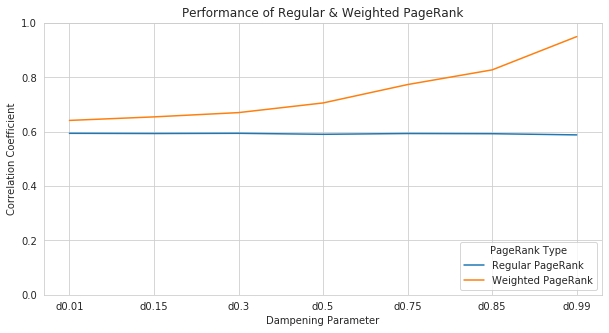

In [80]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylim((0, 1))
ax.set_title("Performance of Regular & Weighted PageRank")
sns.lineplot(x="d value", y="value", hue="variable", data=updated_corr_df, ax=ax)
plt.legend(title="PageRank Type", loc='lower right', labels=['Regular PageRank',
                                                             'Weighted PageRank'])
ax.set(xlabel='Dampening Parameter', ylabel='Correlation Coefficient')
sns.set_style("whitegrid")
plt.show()

In [0]:
weighted_stats = pd.DataFrame(columns=['dampening_val', 'std_dev', 'min', 'max'])
d_vals = [(0.01, 'd0.01'), (0.15, 'd0.15'), (0.30, 'd0.3'), (0.5, 'd0.5'),
            (0.75, 'd0.75'), (0.85, 'd0.85'), (0.99, 'd0.99')]
for value, name in d_vals:
  output_vec = pagerank(weighted_adj_mat, value)
  weighted_stats.loc[len(weighted_stats)] = [value, np.std(output_vec), np.amin(output_vec), np.amax(output_vec)]
weighted_stats['pr_type'] = 'weighted'

In [0]:
normal_stats = pd.DataFrame(columns=['dampening_val', 'std_dev', 'min', 'max'])
for value, name in d_vals:
  output_vec = pagerank(updated_norm_pg_mat, value)
  normal_stats.loc[len(normal_stats)] = [value, np.std(output_vec), np.amin(output_vec), np.amax(output_vec)]
normal_stats['pr_type'] = 'normal'

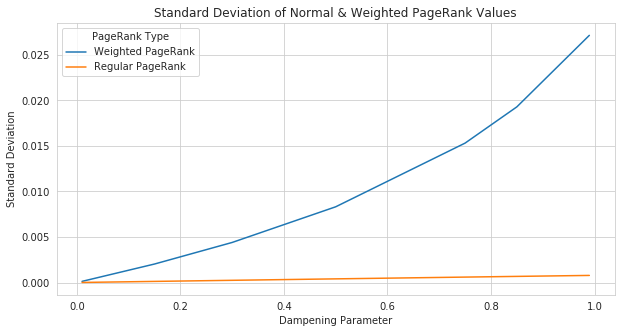

In [70]:
total_stats = pd.concat([weighted_stats, normal_stats])
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Standard Deviation of Normal & Weighted PageRank Values")
sns.set_style("whitegrid")
sns.lineplot(x="dampening_val", y="std_dev", hue="pr_type", data=total_stats, ax=ax)
plt.legend(title="PageRank Type", labels=['Weighted PageRank', 'Regular PageRank'])
ax.set(xlabel='Dampening Parameter', ylabel='Standard Deviation')
plt.show()

In [71]:
total_stats

,dampening_val,std_dev,min,max,pr_type
0,0.01,0.000127,0.012877,0.013637,weighted
1,0.15,0.002032,0.011326,0.023652,weighted
2,0.30,0.004400,0.009630,0.036678,weighted
3,0.50,0.008316,0.007291,0.059203,weighted
4,0.75,0.015311,0.004147,0.101112,weighted
5,0.85,0.019292,0.002758,0.125327,weighted
6,0.99,0.027143,0.000377,0.172935,weighted
0,0.01,0.000008,0.012945,0.012993,normal
1,0.15,0.000122,0.012353,0.013076,normal
2,0.30,0.000243,0.011721,0.013162,normal


In [0]:
weighted_comm_names = ordered_pivot.rename(columns=comm_names_dict)
weighted_comm_names = weighted_comm_names.T.rename(columns=comm_names_dict).T

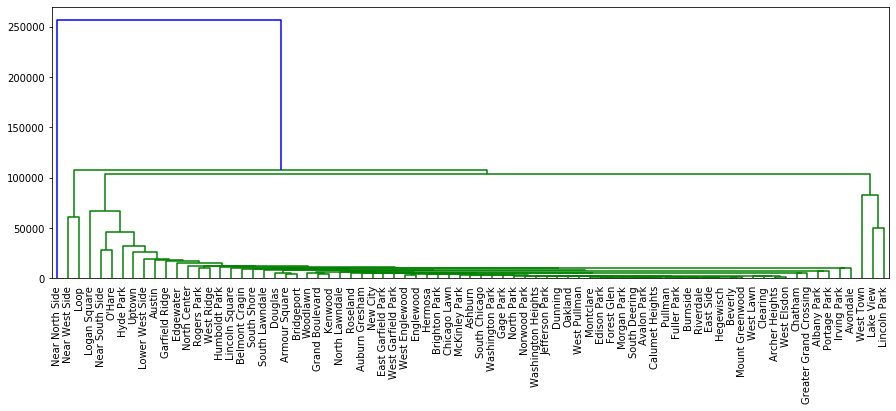

In [0]:
Z = hierarchy.linkage(weighted_comm_names.T, 'single')
plt.figure(figsize=(15, 5))
dn = hierarchy.dendrogram(Z, labels=weighted_comm_names.T.columns, leaf_font_size=10)

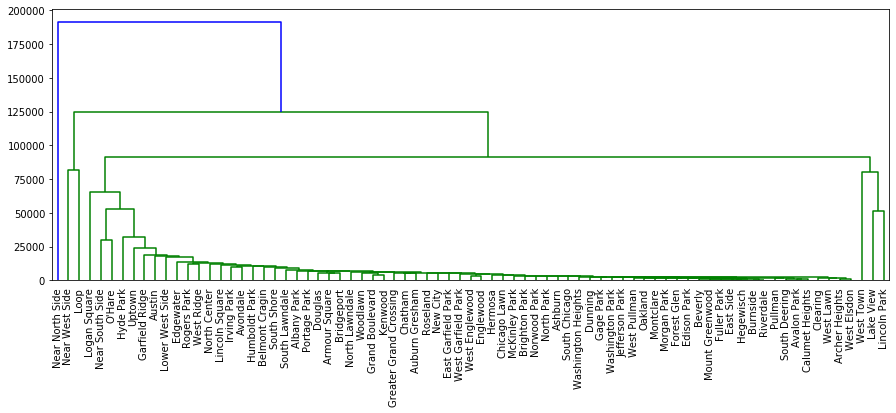

In [0]:
Z = hierarchy.linkage(weighted_comm_names, 'single')
plt.figure(figsize=(15, 5))
dn = hierarchy.dendrogram(Z, labels=weighted_comm_names.columns, leaf_font_size=10)